### Written by  [Gabriel Borges Pinheiro](https://www.github.com/gabrielbopi)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def db(X):
    return 10 * np.log10(np.abs(X))
def inv_db(X):
    return 10**(X/10)
def dbm(X):
    return 10 * np.log10(np.abs(X)/(1e-3))
def inv_dbm(X):
    return (1e-3) * 10**(X/10)

In [3]:
def bases(D, x, y, z_med=15):
    num_x = int(x/D)
    num_y = int(y/D)
    total = num_x*num_y
    n = np.array([])
    for i in range(num_y):
        for j in range(num_x):
            n = np.append(n, np.array([(j*D)+(D/2),(i*D)+(D/2),z_med])) 
        
    return n.reshape(total,3) , total

def usuário(n, x, y):
    z_med = 1.5 #m
    UE = np.array([])
    for i in range(n):
        UE = np.append(UE,np.array([x*np.random.random(),y*np.random.random(),z_med]))
    return UE.reshape(n,3)

- Channel format:
$H(f)=\beta e^{j \phi-j2\pi f \tau}$

In [4]:
def pathloss(R,f):
    """
    Returns the 
    """
    #Carrier frequency
#     f0 = 60e9 #Hz
    #Wavelength
    λ = 3e8/f
    #Linear pathloss
    L_lin =  (λ/(4*np.pi*R))**2
    return L_lin

def rand_channel(D, f=120e3):
    """
    Returns the channel
    """
    c = 3e8 #m/s
    τ = D/c
    L = pathloss(D, f)
    β = np.sqrt(L)# * (np.random.normal(0,np.sqrt(1/2))+1j*np.random.normal(0,np.sqrt(1/2)))

    H = β*np.exp(1j*(-2*np.pi*f*τ))
    return H

#### Calculating parameters

In [5]:
#Espaçamento entre cada BS
gap_bs = 50 #m
#Lados da area de bases (quadrado com bases a cada gap_bs metros)
BS,n_bs = bases(gap_bs, 100, 100,3)
n_ue = 3
#Dropa usuario aleatorio na area dos lados especificados
UE = usuário(n_ue, 100, 100)
#Carrier frequency
f0 = 5e9 #Hz
#User band
Δf = 120e3 #Hz
#Spectral density of noise
N0=-127#dBm

In [6]:
#Numero de frequencias
n_f = 128
f = f0 + Δf*(np.arange(n_f)-n_f/2)
H = np.zeros([n_bs,n_f],dtype='complex')
R = np.zeros([n_bs,3])
φ = np.array([])
for i in range(n_bs):
    R[i] = UE[0]-BS[i]
    for j in range(n_f):
        D = np.linalg.norm(R[i])
        H[i,j] = rand_channel(D,f[j])
        
    φ = np.append(φ,2*np.pi*(np.random.rand()-0.5))
    H[i] = H[i]*np.exp(1j*φ[i])

In [7]:
#Numero de frequencias
n_f = 256
f = f0 + Δf*(np.arange(n_f)-n_f/2)
H = np.zeros([n_ue,n_bs,n_f],dtype='complex')
R = np.zeros([3])
φ = np.zeros([n_ue,n_bs],dtype='float')
for k in range(n_ue):
    for i in range(n_bs):
        R = UE[k]-BS[i]
        for j in range(n_f):
            D = np.linalg.norm(R)
            H[k,i,j] = rand_channel(D,f[j])

        φ[k][i] = 2*np.pi*(np.random.rand()-0.5)
        H[k][i] = H[k][i]*np.exp(1j*φ[k][i])

In [17]:
np.size(H,axis=2)

256

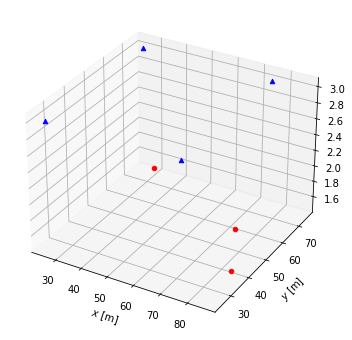

In [8]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
plt.ylabel("$y$ [m]")
plt.xlabel("$x$ [m]")
# plt.zlabel("$z$ [m]")

for i in range(n_bs):
    ax.scatter(BS[i][0], BS[i][1], BS[i][2], marker='^',color='blue')
for n in range(n_ue):
    ax.scatter(UE[n][0], UE[n][1], UE[n][2], marker='o',color='red')

Signal matrix $s(t)$:

In [9]:
P = inv_dbm(30)/n_f
# S(f) generated as a digital randomic diagonal matrix (with 1 or -1)
D = np.random.randint(low=0,high=2,size=n_f)*2-1
S = np.zeros([n_ue,n_f,n_f])
S[::] = np.diag(D)*np.sqrt(P)

In [10]:
P = inv_dbm(30)/n_f
# S(f) generated as a digital randomic diagonal matrix (with 1 or -1)
D = np.random.randint(low=0,high=2,size=n_f)*2-1
S = np.zeros([n_ue,n_f,n_f])
S[::] = np.diag(D)*np.sqrt(P)
#Noise
var_ruido = inv_dbm(-127)*Δf/2 
η = np.random.normal(0,np.sqrt(var_ruido))+1j*np.random.normal(0,np.sqrt(var_ruido))

# np.random.normal(0,np.sqrt(var_ruido))
# Received signal Y(f)
Y = H @ S + η

S_inv = np.linalg.inv(S)
R =  Y@S_inv

for j in range(n_ue):
    for i in range(n_bs):
        R[j][i] = R[j][i]*np.exp(-1j*φ[j][i])

# Vector of delays
h = np.fft.ifft(R)

#Sample rate
fs = n_f*Δf
Ts = 1/fs
t = np.linspace(0,n_f-1,n_f)*Ts

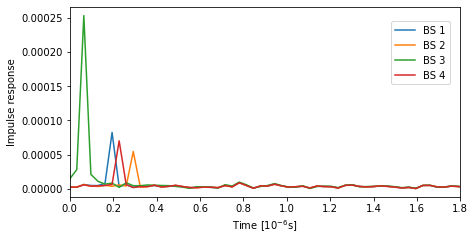

In [133]:
plt.figure(figsize=(7,3.5))

for i in range(n_bs):
    label = ('BS {}'.format(i+1))
    plt.plot(t*1e6,np.abs(h[0][i]),label=label)

plt.ylabel("Impulse response")
plt.xlabel("Time [$10^{-6}$s]")
plt.xlim(0,1.8)
plt.legend(bbox_to_anchor=(0.81, 0.95), loc='upper left')
# plt.grid()

In [134]:
c = 3e8 #m/s
τ_est = np.zeros([n_ue,n_bs])
D_est = np.zeros_like(τ_est)

for j in range(n_ue):
    i_τ = np.apply_along_axis(lambda i:np.argmax(np.abs(i)), 1, h[j])
    τ_est[j]=np.apply_along_axis(lambda k:t[k], 0, i_τ)
    D_est[j] = τ_est[j]*c

#True values:
D = np.zeros_like(D_est)
for j in range(n_ue):
    for i in range(n_bs):
        D[j][i]=np.linalg.norm(BS[i]-UE[j])
    τ = D/c

#Erro de distancia (metros)
erro_D = np.abs(D-D_est)

In [135]:
import pandas as pd

In [136]:
data = np.array([range(1,n_bs+1),τ_est[0]*(1e7), D_est[0], D[0], erro_D[0]]).transpose()
dados = pd.DataFrame(columns=['BS','$\tau$ estimated ($10^{-7}$ s)','D estimated (m)','D real (m)','Error distance (m)'],data=data)
dados = dados.set_index('BS')
dados.head(n_bs)

,$\tau$ estimated ($10^{-7}$ s),D estimated (m),D real (m),Error distance (m)
BS,,,,
1.0,1.953125,58.593750,58.140050,0.453700
2.0,2.929688,87.890625,87.423983,0.466642
3.0,0.651042,19.531250,18.491525,1.039725
4.0,2.278646,68.359375,67.857379,0.501996


#### Trilateration
$\mathbf{A} \mathbf{r}_{est} = \mathbf{b}$

In [137]:
r_est = np.zeros([n_ue,2])
d = np.zeros(2)

for j in range(n_ue):
#New denotations
    d = D_est[j]
    x = BS[:,0]
    y = BS[:,1]

    A = np.array([])
    b = np.array([])
    for i in np.arange(n_bs-1)+1:
        A = np.append(A,[2*(x[i]-x[0]),2*(y[i]-y[0])])
        b = np.append(b,(d[0]**2-d[i]**2)+(-x[0]**2-y[0]**2+x[i]**2+y[i]**2))
    A = A.reshape(n_bs-1,2)

    r_est[j] = np.linalg.inv(A.transpose()@A)@(A.transpose()@b)

In [138]:
r_est

array([[ 7.08465576, 80.51757813],
       [98.00160726, 52.22524007],
       [50.        , 11.85302734]])

In [139]:
UE[::,:2]

array([[ 7.37312582, 80.3832888 ],
       [99.70617156, 58.78979367],
       [54.12444697,  8.32592944]])

No handles with labels found to put in legend.


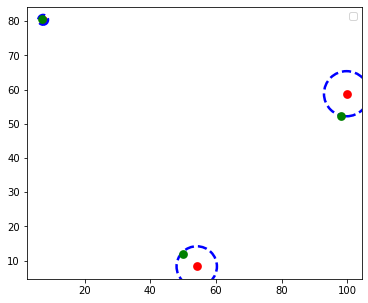

In [144]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)

for n in range(n_ue):
    erro_range[n] = np.linalg.norm(UE[n,:2]-r_est[n])
    ax.scatter(UE[n][0], UE[n][1], marker='o',color='red', linewidths=2.75)
    ax.scatter(UE[n][0], UE[n][1], s=erro_range[n]*300, marker='o',edgecolor='blue',facecolor='none',linestyle='--', linewidths=2.5)
    ax.scatter(r_est[n][0], r_est[n][1], marker='o',color='green', linewidths=2.75)

### Sweeps

In [15]:
def cdf(F,bins=20):
    hist, bins = np.histogram(F, bins)
    pdf = hist/np.sum(hist)
    cdf = np.cumsum(pdf)
    return cdf, pdf, bins

In [55]:
def erro_distancia(BS, UE,f):
    n_bs = np.size(BS,0)
    n_f = np.size(f,0)
    H = np.zeros([n_bs,n_f],dtype='complex')
    R = np.zeros([n_bs,3])
    φ = np.array([])
    
    for i in range(n_bs):
        R[i] = UE[0]-BS[i]
        for j in range(n_f):
            D = np.linalg.norm(R[i])
            H[i,j] = rand_channel(D, f[j])
        φ = np.append(φ,2*np.pi*(np.random.rand()-0.5))
        H[i] = H[i]*np.exp(1j*φ[i])

    P = inv_dbm(30)/n_f
    # S(f) generated as a digital randomic diagonal matrix (with 1 or -1)
    D = np.random.randint(low=0,high=2,size=n_f)*2-1
    S = np.diag(D)*np.sqrt(P)

    #Noise
    var_ruido = inv_dbm(-127)*Δf #N0=-127dBm
    η = np.random.normal(0,np.sqrt(var_ruido/2))+1j*np.random.normal(0,np.sqrt(var_ruido/2))

    # np.random.normal(0,np.sqrt(var_ruido))
    # Received signal Y(f)
    Y = H @ S + η

    S_inv = np.linalg.inv(S)
    R =  Y@S_inv
    
    #Eliminating channel phase effects
    for i in range(n_bs):
        R[i] = R[i]*np.exp(-1j*φ[i])

    # Vector of delays
    h = np.fft.ifft(R)

    #Sample rate
    fs = n_f*Δf
    Ts = 1/fs
    t = np.linspace(0,n_f-1,n_f)*Ts

    i_τ = np.apply_along_axis(lambda i:np.argmax(np.abs(i)), 1, h)
    τ_est=np.apply_along_axis(lambda k:t[k], 0, i_τ)
    c = 3e8 #m/s
    D_est = τ_est*c
    #True values:
    D = np.zeros_like(i_τ)
    for i in range(n_bs):
        D[i]=np.linalg.norm(BS[i]-UE[0])
    #Erro de distancia (metros)
    erro_D = np.abs(D-D_est)
    return erro_D

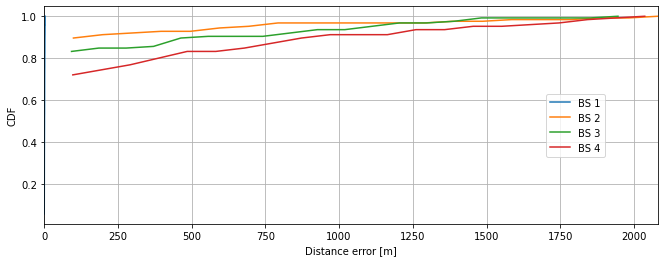

In [56]:
#Plot error CDF (m) for each BS
mc = 125 #Monte Carlo realizations
erro_D = np.zeros([mc,n_bs])
for j in range(mc):
    np.random.seed(j)
    UE = usuário(n_ue, 200, 100)
    erro_D[j] = erro_distancia(BS, UE,f)
#Compute CDF
cdf_erro = []
pdf_erro = []
bins = []
for i in range(n_bs):
    cdf_erroi, pdf_erroi, binsi = cdf(erro_D[:,i],bins=21)
    cdf_erro = np.concatenate([cdf_erro,cdf_erroi])
    pdf_erro = np.concatenate([pdf_erro,pdf_erroi])
    bins = np.concatenate([bins,binsi])
cdf_erro = cdf_erro.reshape([n_bs,np.size(cdf_erroi)])
pdf_erro = pdf_erro.reshape([n_bs,np.size(pdf_erroi)])
bins = bins.reshape([n_bs,np.size(binsi)])

plt.figure(figsize=(11,4))
for i in range(n_bs):
    label = ('BS {}'.format(i+1))
    plt.plot(bins[i,1:],cdf_erro[i], label=label)
plt.ylabel("CDF")
plt.xlabel("Distance error [m]")
plt.xlim(0,np.max(bins))
plt.legend(bbox_to_anchor=(0.81, 0.62), loc='upper left')
plt.grid()

# Plotar grafico variando potencia e outro variando frequencia

- Introducao
- Descriçao do cenario
- Problematica (Proc do sinal recebido)
- Conclusoes (Prox. passos...)

In [118]:
def erro_distancia(BS,UE,f,Δf=120e3,P_db=30):
    n_bs = np.size(BS,0)
    n_f = np.size(f,0)
    P = inv_dbm(P_db)/n_f
    H = np.zeros([n_bs,n_f],dtype='complex')
    R = np.zeros([n_bs,3])
    φ = np.array([])
    for i in range(n_bs):
        R[i] = UE[0]-BS[i]
        for j in range(n_f):
            D = np.linalg.norm(R[i])
            H[i,j] = rand_channel(D, f[j])
        φ = np.append(φ,2*np.pi*(np.random.rand()-0.5))
        H[i] = H[i]*np.exp(1j*φ[i])
        
    # S(f) generated as a digital randomic diagonal matrix (with 1 or -1)
    D = np.random.randint(low=0,high=2,size=n_f)*2-1
    S = np.diag(D)*np.sqrt(P)

    #Noise
    var_ruido = inv_dbm(-127)*Δf/2
    η = np.random.normal(0,np.sqrt(var_ruido))+1j*np.random.normal(0,np.sqrt(var_ruido))
    # Received signal Y(f)
    Y = H @ S + η

    S_inv = np.linalg.inv(S)
    R =  Y@S_inv

    #Eliminating channel phase effects
    for i in range(n_bs):
        R[i] = R[i]*np.exp(-1j*φ[i])
    
    # Vector of delays
    h = np.fft.ifft(R)

    #Sample rate
    fs = n_f*Δf
    Ts = 1/fs
    t = np.linspace(0,n_f-1,n_f)*Ts

    i_τ = np.apply_along_axis(lambda i:np.argmax(np.abs(i)), 1, h)
    τ_est=np.apply_along_axis(lambda k:t[k], 0, i_τ)
    c = 3e8 #m/s
    D_est = τ_est*c
    #True values:
    D = np.zeros_like(i_τ)
    for i in range(n_bs):
        D[i]=np.linalg.norm(BS[i]-UE[0])
    #Erro de distancia (metros)
    erro_D = np.abs(D-D_est)
    return erro_D

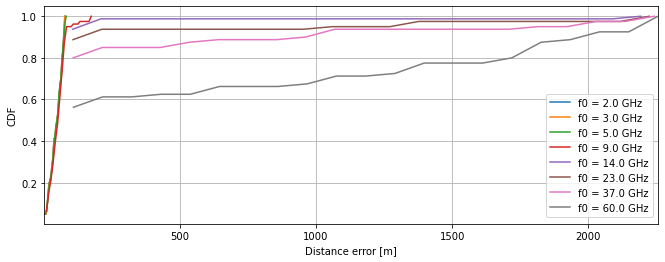

In [119]:
#Plot error CDF (m) for ranging carrier frequencies
mc = 10 #Monte Carlo realizations
p_db = 30#dB
n_f = 16
# N_f = np.round(np.linspace(1,60,7))
N_f = np.round(np.logspace(1,np.log2(60),8,base=2))*1e9
cdf_erro=[]; pdf_erro=[]; bins=[];
erro_D = np.zeros([mc,n_bs])

for f0 in N_f:
    f = f0 + Δf*(np.arange(n_f)-n_f/2) #Hz
    #Compute CDF
    for j in range(mc):
        np.random.seed(j)
        UE = usuário(n_ue, 200, 100)
        erro_D[j] = erro_distancia(BS,UE,f,Δf,p_db)
    erro_Dtot = erro_D.reshape([n_bs*mc])
    cdf_erroi, pdf_erroi, binsi = cdf(erro_Dtot,bins=21)
    cdf_erro = np.concatenate([cdf_erro,cdf_erroi])
    pdf_erro = np.concatenate([pdf_erro,pdf_erroi])
    bins = np.concatenate([bins,binsi])
cdf_erro = cdf_erro.reshape([len(N_f),np.size(cdf_erroi)])
pdf_erro = pdf_erro.reshape([(len(N_f)),np.size(pdf_erroi)])
bins = bins.reshape([(len(N_f)),np.size(binsi)])
#PLOTs
plt.figure(figsize=(11,4))
for f0,i in zip(N_f*1e-9,range(len(N_f))):
    label = ('f0 = {} GHz'.format(np.round(f0))) 
    plt.plot(bins[i,1:],cdf_erro[i], label=label)
plt.ylabel("CDF")
plt.xlabel("Distance error [m]")
plt.xlim(np.min(bins),np.max(bins))
plt.legend(bbox_to_anchor=(0.81, 0.62), loc='upper left')
plt.grid()

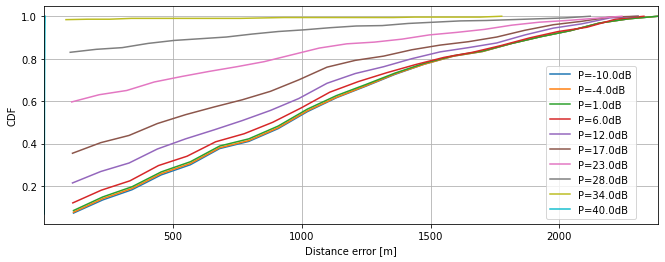

In [63]:
#Plot error CDF (m) for a set of strengths (P_db)
mc = 125 #Monte Carlo realizations
f0 = 5e9 #Hz
n_f = 512
f = f0 + Δf*(np.arange(n_f)-n_f/2)
nPot = 10
P_db = np.linspace(-10,40,nPot) #dB
cdf_erro=[]; pdf_erro=[]; bins=[];

for p_db,i in zip(P_db,range(nPot)):
    erro_D = np.zeros([mc,n_bs])

    #Compute CDF
    for j in range(mc):
        np.random.seed(j)
        UE = usuário(n_ue, 200, 100)
        erro_D[j] = erro_distancia(BS,UE,f,Δf,p_db)
    erro_Dtot = erro_D.reshape([n_bs*mc])
    cdf_erroi, pdf_erroi, binsi = cdf(erro_Dtot,bins=21)
    cdf_erro = np.concatenate([cdf_erro,cdf_erroi])
    pdf_erro = np.concatenate([pdf_erro,pdf_erroi])
    bins = np.concatenate([bins,binsi])
cdf_erro = cdf_erro.reshape([nPot,np.size(cdf_erroi)])
pdf_erro = pdf_erro.reshape([nPot,np.size(pdf_erroi)])
bins = bins.reshape([nPot,np.size(binsi)])
#PLOTs
plt.figure(figsize=(11,4))
for p_db,i in zip(P_db,range(nPot)):
    label = ('P={}dBm'.format(np.trunc(p_db))) 
    plt.plot(bins[i,1:],cdf_erro[i], label=label)
plt.ylabel("CDF")
plt.xlabel("Distance error [m]")
plt.xlim(np.min(bins),np.max(bins))
plt.legend(bbox_to_anchor=(0.81, 0.75), loc='upper left')
plt.grid()

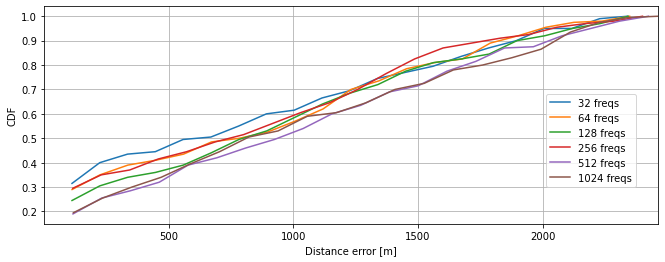

In [67]:
#Plot error CDF (m) for a set of number of frequencies
mc = 200 #Monte Carlo realizations
f0=60e9
p_db = 30#dB
N_f = 2**np.arange(5,11)
cdf_erro=[]; pdf_erro=[]; bins=[];
erro_D = np.zeros([mc,n_bs])

for n_f in N_f:
    f = f0 + Δf*(np.arange(n_f)-n_f/2) #Hz
    #Compute CDF
    for j in range(mc):
        np.random.seed(j)
        UE = usuário(n_ue, 200, 100)
        erro_D[j] = erro_distancia(BS,UE,f,Δf,p_db)
    erro_Dtot = erro_D.reshape([n_bs*mc])
    cdf_erroi, pdf_erroi, binsi = cdf(erro_Dtot,bins=21)
    cdf_erro = np.concatenate([cdf_erro,cdf_erroi])
    pdf_erro = np.concatenate([pdf_erro,pdf_erroi])
    bins = np.concatenate([bins,binsi])
cdf_erro = cdf_erro.reshape([len(N_f),np.size(cdf_erroi)])
pdf_erro = pdf_erro.reshape([(len(N_f)),np.size(pdf_erroi)])
bins = bins.reshape([(len(N_f)),np.size(binsi)])
#PLOTs
plt.figure(figsize=(11,4))
for n_f,i in zip(N_f,range(len(N_f))):
    label = ('{} carriers'.format(n_f)) 
    plt.plot(bins[i,1:],cdf_erro[i], label=label)
plt.ylabel("CDF")
plt.xlabel("Distance error [m]")
plt.xlim(np.min(bins),np.max(bins))
plt.legend(bbox_to_anchor=(0.81, 0.62), loc='upper left')
plt.grid()

#### Simular 1 BS em 30dBm variando distancia do UE (a cada 10 ate 100m) (circular) (512 carriers)
Consertar fases do canal (1 para cada BS)

In [65]:
def usuárioR(n, R):
    z_med = 1.5 #m
    UE = np.array([])
    for i in range(n):
        φ = 2*np.pi*(np.random.rand()-0.5)
        UE = np.append(UE,np.array([R*np.cos(φ),R*np.sin(φ),z_med]))
    return UE.reshape(n,3)

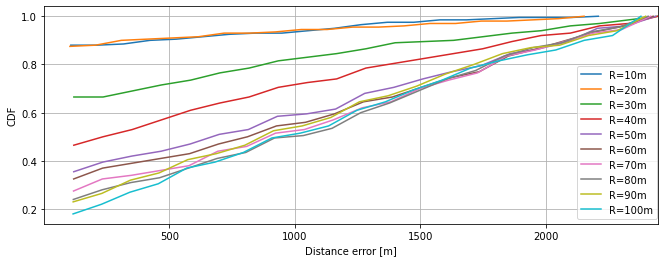

In [68]:
#Plot error CDF (m) for a set of R
mc = 200 #Monte Carlo realizations
z_bs=15
BS = np.array([[0,0,z_bs]]); n_bs = np.size(BS,axis=0)
n_f = 512
f = f0 + Δf*(np.arange(n_f)-n_f/2)
p_db = 30 #dBm
# nPot = 10
# P_db = np.linspace(-10,40,nPot) #dB
n_r = 10
R = np.linspace(10,100,n_r)
cdf_erro=[]; pdf_erro=[]; bins=[];

for r,i in zip(R,range(n_r)):
    erro_D = np.zeros([mc,n_bs])

    #Compute CDF
    for j in range(mc):
        np.random.seed(j)
        UE = usuárioR(n_ue, r)
        erro_D[j] = erro_distancia(BS,UE,f,Δf,p_db)
    erro_Dtot = erro_D.reshape([n_bs*mc])
    cdf_erroi, pdf_erroi, binsi = cdf(erro_Dtot,bins=21)
    cdf_erro = np.concatenate([cdf_erro,cdf_erroi])
    pdf_erro = np.concatenate([pdf_erro,pdf_erroi])
    bins = np.concatenate([bins,binsi])
cdf_erro = cdf_erro.reshape([n_r,np.size(cdf_erroi)])
pdf_erro = pdf_erro.reshape([n_r,np.size(pdf_erroi)])
bins = bins.reshape([n_r,np.size(binsi)])
#PLOTs
plt.figure(figsize=(11,4))
for r,i in zip(R,range(n_r)):
    label = ('R={}m'.format(round(r))) 
    plt.plot(bins[i,1:],cdf_erro[i], label=label)
plt.ylabel("CDF")
plt.xlabel("Distance error [m]")
plt.xlim(np.min(bins),np.max(bins))
plt.legend(bbox_to_anchor=(0.86, 0.75), loc='upper left')
plt.grid()

In [22]:
# import commpy #sequencias piloto

In [34]:
f0=5.5e9
λ = 3e8/f0
#Linear pathloss
Gr=inv_db(7.3)
Gt=15
Pr_Pt=inv_dbm(-25)/1
R =  (λ/(4*np.pi))*np.sqrt(Gr*Gt/Pr_Pt)
R

21.907576188853778

In [74]:
np.size(f)

512

In [76]:
np.size(rand_channel(10,f))

512